## Load R-libraries

In [1]:
library(rjson)
library(tidyverse)
library(scales)
library(emmeans)
library(lmerTest)
library(plotly)
library(Rtsne)
library(gridExtra)
library(dbscan)

library(reticulate)
np <- import('numpy')

options(repr.matrix.max.cols=70, repr.matrix.max.rows=100)
options(repr.plot.width=20, repr.plot.height=20)

`%ni%` = Negate(`%in%`)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot



## Locate and retrieve data

The code in this notebook works if the underlying folder structure where data types are stored adheres to the following structure: 

* a parent folder (e.g.: '/project') 
* a first subfolder in which you only have subfolders per concept (e.g.: 'project/models/television'or 'project/models/shop')
* in each concept folder you have three data types:
    * the sampled tokens in a tsv file
    * the cosine distance matrices created by means of the `nephosem` python module (where the matrices themselves are stored in npy-format and the metadata (i.e. the row- and column names) are stored separetely in meta-format)

In [2]:
path = "/home/projects/semmetrix/NephoSem/output-data/new-chapter10/models/"
# path = "YOUR/PATH/TO/DIRECTORY/models/"

ld <- list.dirs(path=path, full=F, recursive=F)
concepts <- ld[! ld %in% c("tmp", ".ipynb_checkpoints","TEMPLATES")]
length(concepts) # how many concepts do I have? 

[1] 85

###  1. Retrieve a dictionary (i.e. a Json object) with a concept and variants mapping

Example

`{
'TELEVISION' : ['television', 'tv'],
 'SHOP' : ['shop', 'store']
 }`

In [3]:
conceptsvariants = fromJSON(file = '/home/projects/semmetrix/NephoSem/output-data/new-chapter10/conceptsvariants.json')
# conceptsvariants = fromJSON(file = 'YOUR/PATH/TO/DIRECTORY/project/yourconceptsandvariantsdict.json')


d.conceptsvariants = data.frame()
for (n1 in names(conceptsvariants)) {
    for (n2 in names(conceptsvariants[[n1]])) {
        for (n3 in conceptsvariants[[n1]][[n2]]) {
            d.conceptsvariants <- rbind(d.conceptsvariants, cbind(concept=n1,lemma=n2,wordform=n3))           
        }
    } 
}

### 2. Retrieve a file with the token id's of the tokens that have been sampled to create the token-based models


In [4]:
startingTokens <- scan(file = "/home/projects/semmetrix/NephoSem/output-data/new-chapter10/sampled_tokens_chapter10.csv", what = 'character', sep = '\n')
# startingTokens <- scan(file = "YOUR/PATH/TO/DIRECTORY/project/sampled_tokens_chapter10.csv", what = 'character', sep = '\n')

### 3. Retrieve the files with the manual annotations

In your project directory you should have a folder 'annotations' that contains the annotation files per concept. 
Such an annotation file is a text file (tsv or csv) with at least the following information:
* a column with the token id's
* a column with the concept annotation (i.e. 'yes' or 'no')

Example

| token-id | ... (extra columns with context)... | annotation |
| --- | --- | --- |
| misstand;misstand/86-twitter-nl/39038 | middag ... # integriteit # defensiegate @ defensieonline - oorlogvoeren tegen eigen # personeel is verwerpelijk , een zeer ernstige;misstand;en # moreelondermijnend : meld # misstand bij # meldpunt sociaal veilige werkomgeving # defensie https://t.co/wrfsvsdihg https://t.co/lp07j2vqk7 @ nporadio2 er | yes |
| misstand;misstand/74-twitter-nl/68806 | willen de wérkelijke problemen bij @ defensie kennen en helpen deze duurzaam op te lossen : meld daarom elke #;misstand;bij # meldpunt sociaal veilige werkomgeving # defensie https://t.co/wrfsvsdihg https://t.co/2ykwkclru9 @ axelosch @ vetleuk nee , deze gap is echt | no |

In [5]:
annotationPath <- "/home/projects/semmetrix/NephoSem/output-data/new-chapter10/annotations/"
# annotationPath <- "YOUR/PATH/TO/DIRECTORY/project/annotations/"


d.annotation <- data.frame()
for (file in list.files(annotationPath)) {
    annotationTemp <- read.csv2(paste0(annotationPath,file), header=T)
    d.annotation <- rbind(d.annotation, annotationTemp)
}

rownames(d.annotation) <- d.annotation$Column2

`summarise()` regrouping output by 'concept' (override with `.groups` argument)



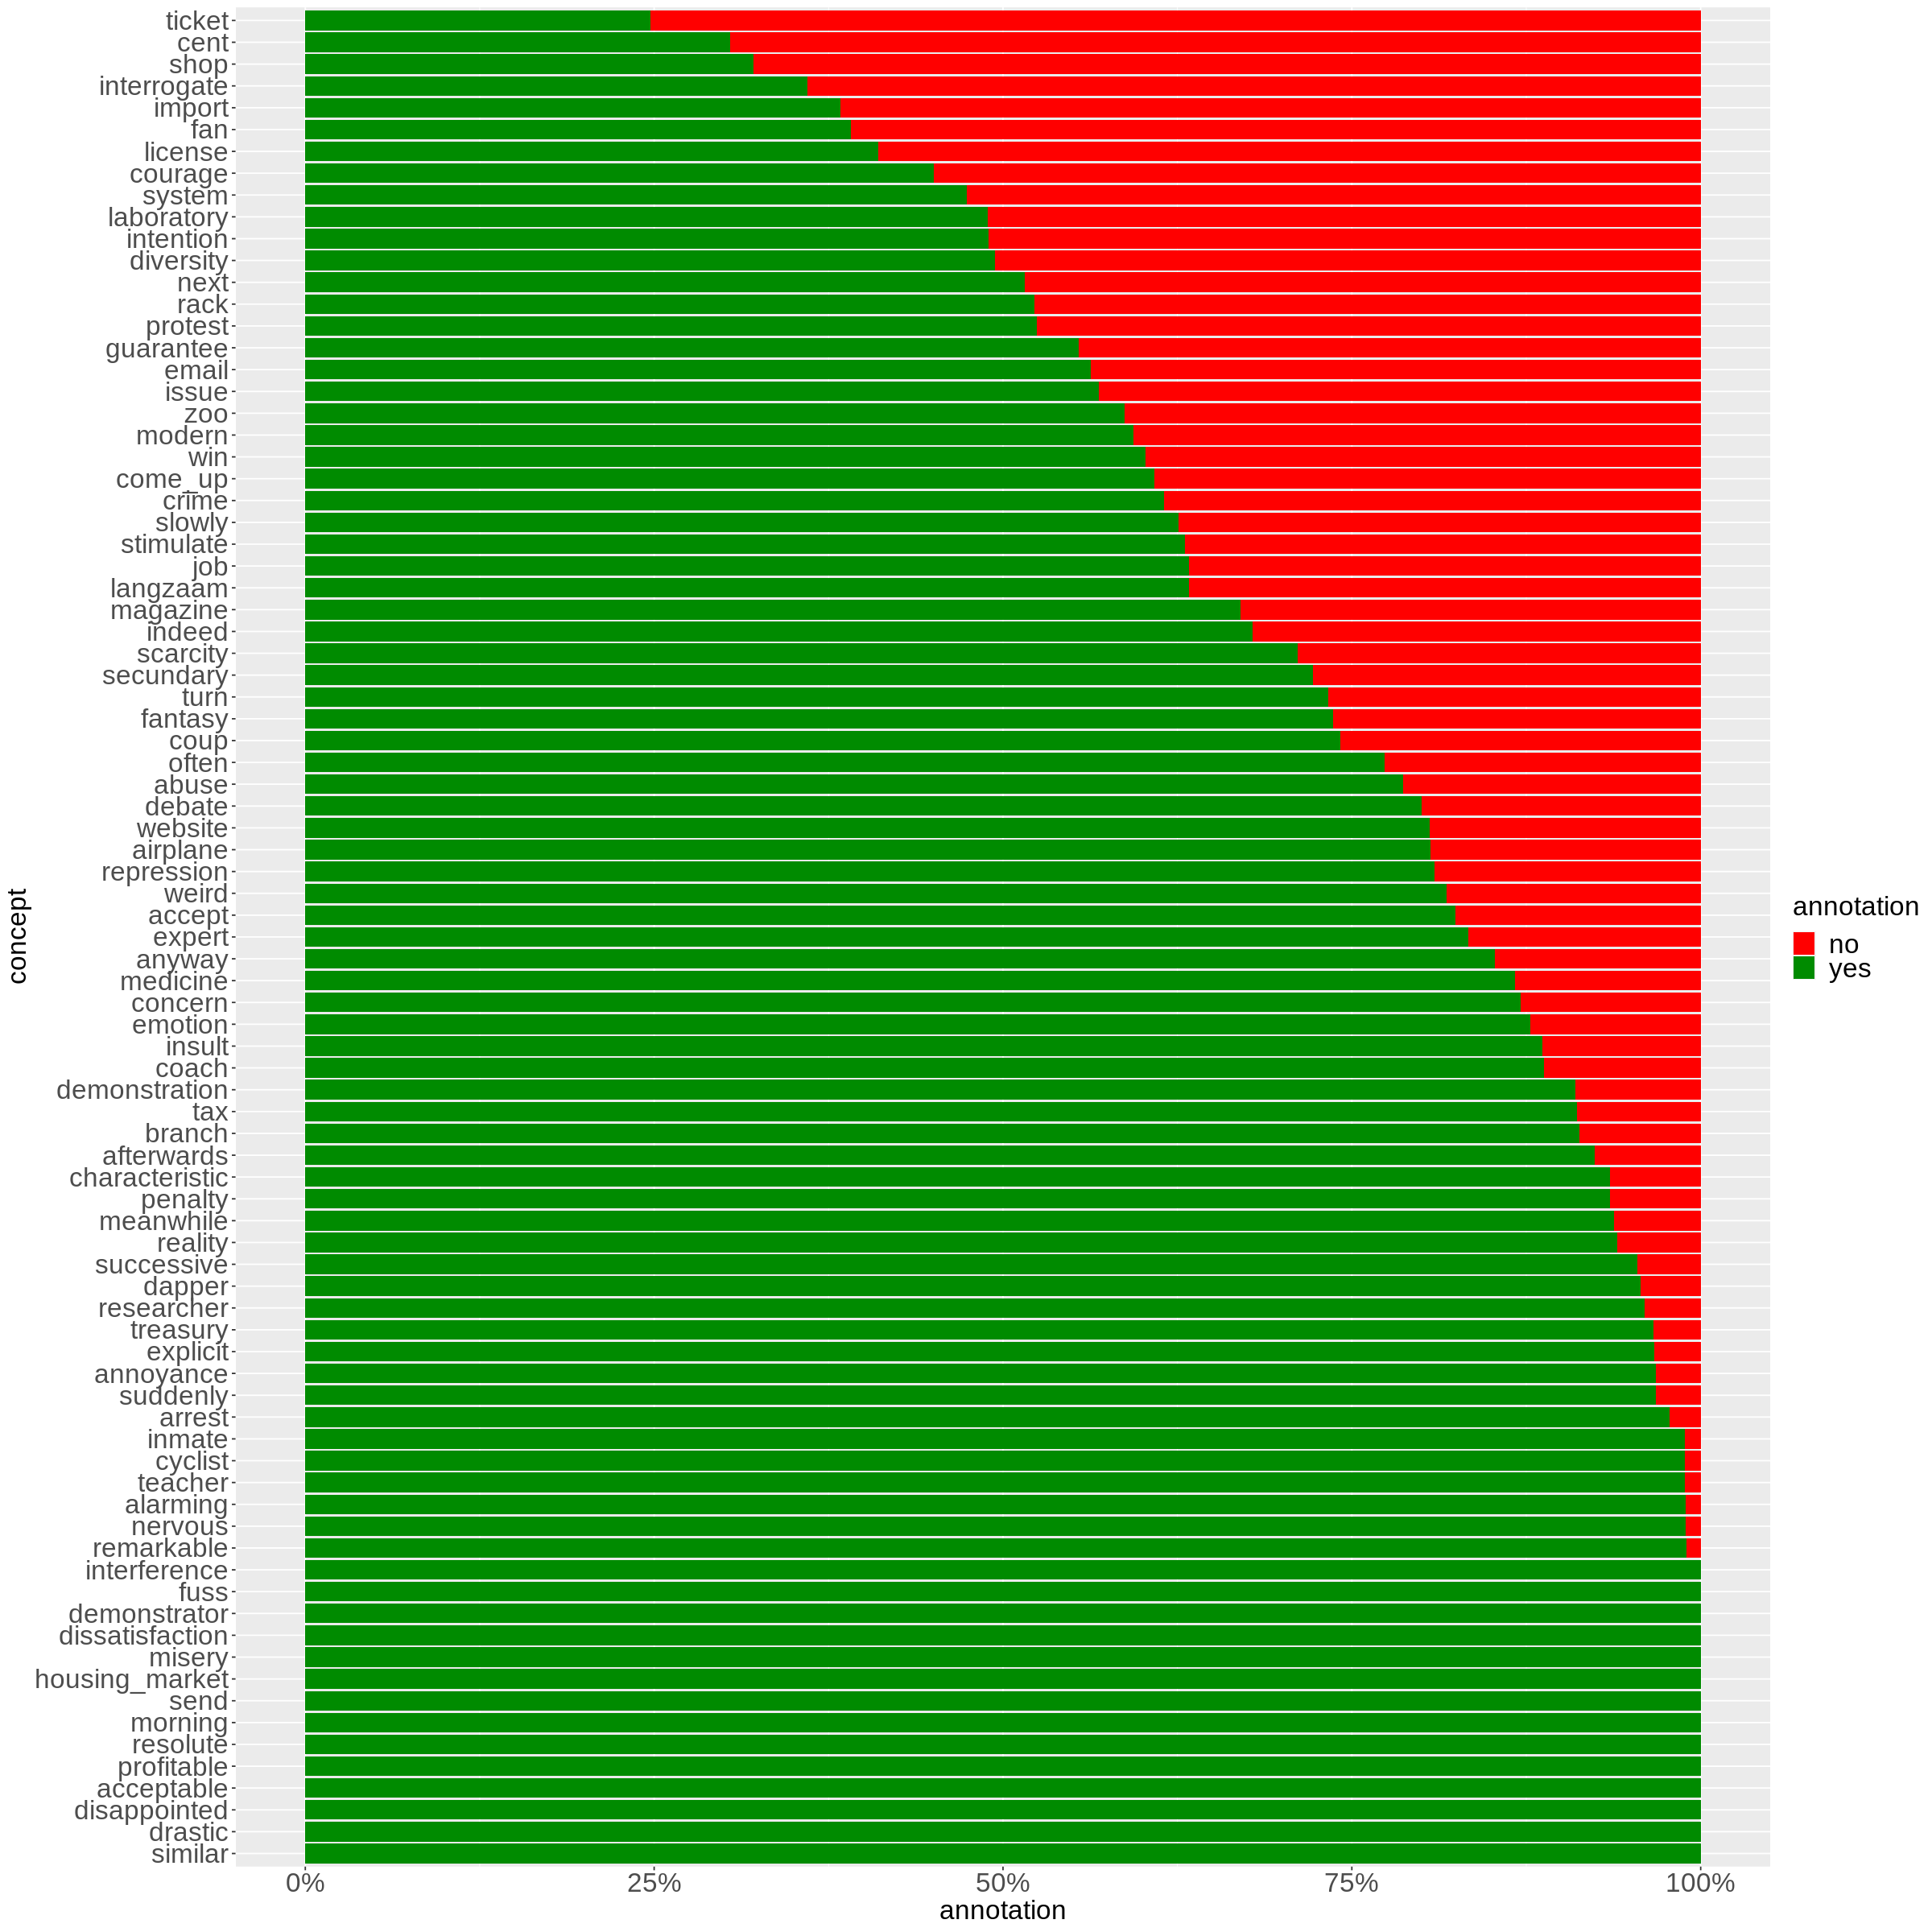

In [6]:
# Check the distribution of in-concept and out-of-concept tokens over the different concepts

d.annotation2 <- merge(d.annotation, d.conceptsvariants, by.x=c("Column1"), by.y=c("wordform")) 

new.level.annotation2 <- d.annotation2 %>% 
group_by(concept, annotation) %>% 
summarize(n=n()) %>%
mutate(freq = n / sum(n)) %>%
filter(annotation == "yes") %>%
arrange(desc(freq)) %>%
pull(concept) %>%
as.character()

d.annotation2$concept <- factor(d.annotation2$concept, levels=new.level.annotation2)


ggplot(d.annotation2, aes(x=annotation, y=concept)) + 
geom_bar(aes(x = (..count..)/tapply(..count.., ..y.. ,sum)[..y..], fill=annotation)) +
scale_fill_manual(values=c("red","green4")) + 
theme(axis.text.x = element_text(size=20), 
      axis.text.y = element_text(size=20),
      axis.title = element_text(size=20), 
      strip.text = element_text(size = 20),
      legend.text = element_text(size=20),
      legend.title = element_text(size= 20),
      plot.title = element_text(size=20)) + 
scale_x_continuous(labels = scales::percent)

### 4. Retrieve the file with the original size information of the concepts

Example

| concept | original_size | sample_size | proportion_sample |
| --- | --- | --- | --- |
| television | 73954 | 1400 | 0.02 |
| shop | 8667 | 100 | 0.12 |

In [7]:
pd <- import("pandas")
concept_count_proportions <- pd$read_pickle("/home/stefano/CH10-diachronic-lectometry/concept_count_proportions")
# concept_count_proportions <- pd$read_pickle("YOUR/PATH/TO/DIRECTORY/project/concept_count_proportions")
 
colnames(concept_count_proportions) <- c("concept", "original_size", "sample_size", "proportion_sample")

## Create plots for token clouds
* static plots of the token clouds per model per concept
* interactive plots of the token clouds per model per concept

To avoid having tens or hundreds of plots, there are two options to limit this plotting procedure:
* you only sample a random number of models for which you want to create plots of token clouds (e.g.: 9 or less)
* you only sample 'good candidate' models to plot (which is based on the number of clusters [enough, but not too many], the presence of multiple annotated clusters, etc.)

In [8]:
nsample = 9

goodCandidates = TRUE

plots_static1 <- list()
plots_static2 <- list()
plots_dynamic <- list()
datasets <- list()

for (con in concepts[1:2]) {
  
  all.models <- tools::file_path_sans_ext(list.files(path=paste0(path,con), pattern=".*npy$")) 
  all.models <- sample(all.models)
  
  if (goodCandidates == FALSE) {
    
    set.seed(1992)
    selected.models <- sample(all.models,nsample)
    
    for (model in selected.models) { #concept_medoids[[css]][[con]]) {
      
      print(model)
      flush.console()
      
      d <- np$load(paste0(path,con,"/",model,".npy"))
      tokenids <- fromJSON(file = paste0(path,con,"/",model,".meta"))
      
      colnames(d) <- tokenids$row_items
      rownames(d) <- tokenids$row_items
      
      tsvfile <- paste0(substr(model,1,nchar(model)-5),".tsv")
      
      # open and store dataframe
      d.tsv <- read.csv(paste0(path,"/",con,"/",tsvfile), header=T, sep="\t", quote="", check.names = F)
      
      # insert line breaks every 40 characters in the concordance of a token
      # (in order to avoid long stretches of context in the visualization)
      d.tsv$`_ctxt.model` <- gsub("(.{40,}?)\\s", "\\1<br>", d.tsv$`_ctxt.model`)
      # target token in bold face
      d.tsv$`_ctxt.model` <- gsub("<span(<br>|\\s)class='target'>([^<]+)</span>", "<b>\\2</b>", d.tsv$`_ctxt.model`)
      # significant concontext words in italics
      d.tsv$`_ctxt.model` <- gsub("<u>([^<]+)</u>", "<i>\\1</i>", d.tsv$`_ctxt.model`)
      # remove 'small font' tags for concontext words outside of concontext window
      d.tsv$`_ctxt.model` <- gsub("</?small>", "", d.tsv$`_ctxt.model`)
      d.tsv$context <- d.tsv$`_ctxt.model`
      
      dsub <- d
      
      dmx1 <- as.matrix(dsub)   
      ranks1 <- t(apply(dmx1, 1, rank))
      ranks1 <- log(1 + log(ranks1))
      dst <- as.dist(as.matrix(dist(ranks1, diag=T, upper=T)))
      
      set.seed(1992)
      fitTSNE <- Rtsne(dst, dims=2, perplexity=30, theta=0.0, check.duplicates=FALSE, max_iter=1000, is_distance=TRUE)
      tsne.x <- fitTSNE$Y[,1]
      tsne.y <- fitTSNE$Y[,2]
      
      wordform <- gsub("^([^/]+)/.+","\\1",rownames(dsub),perl=T)
      lemma <- wordform      
      lemma <- as.factor(lemma)   
      levels(lemma) <- as.character(d.conceptsvariants[which(d.conceptsvariants$wordform %in% levels(lemma)),'lemma'])
      
      lect <- gsub("^[^/]+/.*(nrc1999|nrc2000|stan2000|stan1999|twitter-nl|twitter-be|usenet-nl|usenet-be|nrc2017|standaard2017|standaard2018|nrc2018).+",'\\1',rownames(dsub),perl=T)
      country <- lect
      formality <- lect
      time <- lect
      
      country <- as.factor(country)
      levels(country)[grepl("(nrc|-nl)", levels(country))] <- "NL-Du"
      levels(country)[grepl("(standaard|stan|-be)", levels(country))] <- "BE-Du"
      
      formality <- as.factor(formality)
      levels(formality)[grepl("(nrc|stan)", levels(formality))] <- "formal"
      levels(formality)[grepl("(twitter|usenet)", levels(formality))] <- "informal"
      
      time <- as.factor(time)
      levels(time)[grepl("(2000|1999|usenet)", levels(time))] <- "time1"
      levels(time)[grepl("(2017|2018|twitter)", levels(time))] <- "time2"
      
      d.tsne <- data.frame(tsne.x, tsne.y, wordform=wordform, lemma=lemma, region=country, formality=formality, time=time)
      rownames(d.tsne) <- rownames(dsub)
      
      d.tsne$annotation <- "unk"
      sharedTokens <- intersect(rownames(d.tsne), rownames(d.annotation))
      d.tsne[sharedTokens,"annotation"] <- as.character(d.annotation[sharedTokens,"annotation"])        
      
      d.tsne[as.character(d.tsv$`_id`),"context"] <- d.tsv$context
      
      hdbs.output <- hdbscan(dst, minPts = 8)
      d.tsne$cluster.hdbs <- as.factor(as.character(hdbs.output$cluster))
      d.tsne$membership <- hdbs.output$membership_prob
      
      d.tsne$index <- 1:nrow(d.tsne)
      
      datasets[[con]][[model]] <- d.tsne
      
      d.tsne$annotationNew <- as.factor(d.tsne$annotation)
      d.tsne$annotationNew <- factor(d.tsne$annotationNew, levels = union("unk", levels(as.factor(d.tsne$annotationNew)))) # c("unk", "no","yes"))
      d.tsne$annotation <- factor(d.tsne$annotation, levels = union("unk", levels(as.factor(d.tsne$annotation))))
      levels(d.tsne$annotationNew) <- c("unk", rep("ann", nlevels(as.factor(d.tsne$annotationNew))-1))
    
      static.plot1 <- ggplot(d.tsne, aes(tsne.x,tsne.y)) + 
        geom_point(aes(color=cluster.hdbs, shape=annotation, text=paste('<b>Country</b>: ', region,
                                                                        '</br><b>Word</b>: ', lemma,
                                                                        '</br><b>Concontext</b>: ', context,
                                                                        '</br><b>Token</b>: ', d.tsne$id)), 
                   stroke=1, size=(as.numeric(as.factor(d.tsne$annotationNew))**2)) + 
        scale_shape_manual(values=c(3,17,16)) +
        scale_color_manual(values=c("grey",hue_pal()(nlevels(d.tsne$cluster.hdbs)-1)))  + 
        theme_bw() + coord_fixed() + #ggtitle(model) + 
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank(),
              axis.text=element_text(size=12),
              legend.title=element_text(size=12), 
              legend.text=element_text(size=12), 
              legend.position="right", legend.box = "vertical", 
              plot.title=element_text(size=12)) + 
        guides(color = guide_legend(override.aes=list(size=10)),
               shape = guide_legend(override.aes=list(size=10)))
      
      
      plots_static1[[con]][[model]] <- static.plot1
      
      static.plot2 <- ggplot(d.tsne, aes(tsne.x,tsne.y)) + 
        geom_point(aes(color=lemma, shape=region, text=paste('<b>Country</b>: ', region,
                                                             '</br><b>Word</b>: ', lemma,
                                                             '</br><b>Concontext</b>: ', context,
                                                             '</br><b>Token</b>: ', d.tsne$id)), size=2) + #, size=as.numeric(as.factor(d.tsne$annotationNew))**3) + 
        scale_shape_manual(values=c(4,16)) +
        scale_color_manual(values=c("red", "black"))  + 
        theme_bw() + coord_fixed() + #ggtitle(model) + 
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank(),
              axis.text=element_text(size=12),
              legend.title=element_text(size=12), 
              legend.text=element_text(size=12), 
              legend.position="right", legend.box = "vertical",
              plot.title=element_text(size=12)) + 
        guides(color = guide_legend(override.aes=list(shape = "—", size=10)),
               shape = guide_legend(override.aes=list(size=10)))
      
      
      plots_static2[[con]][[model]] <- static.plot2
      
      plots_dynamic[[con]][[model]] <- ggplotly(static.plot2, tooltip = 'text', opacity=0.5) %>% layout(hoverlabel = list(bgcolor=c("rgb(255,255,204")),
                                                                                           xaxis = list(scaleanchor = "y", scaleratio = 1))  

    }
    
  } else {
    
    ncandidates = 0  
    
    for (model in all.models) { 
      
      print(model)
      flush.console()
      
      d <- np$load(paste0(path,con,"/",model,".npy"))
      tokenids <- fromJSON(file = paste0(path,con,"/",model,".meta"))
      
      colnames(d) <- tokenids$row_items
      rownames(d) <- tokenids$row_items
      
      tsvfile <- paste0(substr(model,1,nchar(model)-5),".tsv")
      
      # open and store dataframe
      d.tsv <- read.csv(paste0(path,"/",con,"/",tsvfile), header=T, sep="\t", quote="", check.names = F)
      
      # insert line breaks every 40 characters in the concordance of a token
      # (in order to avoid long stretches of context in the visualization)
      d.tsv$`_ctxt.model` <- gsub("(.{40,}?)\\s", "\\1<br>", d.tsv$`_ctxt.model`)
      # target token in bold face
      d.tsv$`_ctxt.model` <- gsub("<span(<br>|\\s)class='target'>([^<]+)</span>", "<b>\\2</b>", d.tsv$`_ctxt.model`)
      # significant concontext words in italics
      d.tsv$`_ctxt.model` <- gsub("<u>([^<]+)</u>", "<i>\\1</i>", d.tsv$`_ctxt.model`)
      # remove 'small font' tags for concontext words outside of concontext window
      d.tsv$`_ctxt.model` <- gsub("</?small>", "", d.tsv$`_ctxt.model`)
      d.tsv$context <- d.tsv$`_ctxt.model`
      
      dsub <- d
      
      dmx1 <- as.matrix(dsub)   
      ranks1 <- t(apply(dmx1, 1, rank))
      ranks1 <- log(1 + log(ranks1))
      dst <- as.dist(as.matrix(dist(ranks1, diag=T, upper=T)))
      
      set.seed(1992)
      fitTSNE <- Rtsne(dst, dims=2, perplexity=30, theta=0.0, check.duplicates=FALSE, max_iter=1000, is_distance=TRUE)
      tsne.x <- fitTSNE$Y[,1]
      tsne.y <- fitTSNE$Y[,2]
      
      wordform <- gsub("^([^/]+)/.+","\\1",rownames(dsub),perl=T)
      lemma <- wordform      
      lemma <- as.factor(lemma)   
      levels(lemma) <- as.character(d.conceptsvariants[which(d.conceptsvariants$wordform %in% levels(lemma)),'lemma'])
      
      lect <- gsub("^[^/]+/.*(nrc1999|nrc2000|stan2000|stan1999|twitter-nl|twitter-be|usenet-nl|usenet-be|nrc2017|standaard2017|standaard2018|nrc2018).+",'\\1',rownames(dsub),perl=T)
      country <- lect
      formality <- lect
      time <- lect
      
      country <- as.factor(country)
      levels(country)[grepl("(nrc|-nl)", levels(country))] <- "NL-Du"
      levels(country)[grepl("(standaard|stan|-be)", levels(country))] <- "BE-Du"
      
      formality <- as.factor(formality)
      levels(formality)[grepl("(nrc|stan)", levels(formality))] <- "formal"
      levels(formality)[grepl("(twitter|usenet)", levels(formality))] <- "informal"
      
      time <- as.factor(time)
      levels(time)[grepl("(2000|1999|usenet)", levels(time))] <- "time1"
      levels(time)[grepl("(2017|2018|twitter)", levels(time))] <- "time2"
      
      d.tsne <- data.frame(tsne.x, tsne.y, wordform=wordform, lemma=lemma, region=country, formality=formality, time=time)
      rownames(d.tsne) <- rownames(dsub)
      
      d.tsne$annotation <- "unk"
      sharedTokens <- intersect(rownames(d.tsne), rownames(d.annotation))
      d.tsne[sharedTokens,"annotation"] <- as.character(d.annotation[sharedTokens,"annotation"])        
      
      d.tsne[as.character(d.tsv$`_id`),"context"] <- d.tsv$context
      
      hdbs.output <- hdbscan(dst, minPts = 8)
      d.tsne$cluster.hdbs <- as.factor(as.character(hdbs.output$cluster))
      d.tsne$membership <- hdbs.output$membership_prob
      
      d.tsne$index <- 1:nrow(d.tsne)
      
      d.tsne$annotationNew <- as.factor(d.tsne$annotation)
      d.tsne$annotationNew <- factor(d.tsne$annotationNew, levels = union("unk", levels(as.factor(d.tsne$annotationNew)))) # c("unk", "no","yes"))
      d.tsne$annotation <- factor(d.tsne$annotation, levels = union("unk", levels(as.factor(d.tsne$annotation))))
      levels(d.tsne$annotationNew) <- c("unk", rep("ann", nlevels(as.factor(d.tsne$annotationNew))-1))
      
      t <- table(d.tsne$cluster.hdbs, d.tsne$annotation)
      t.ann <- t[,colnames(t) != "unk"]
      
      if (
        # length(colnames(t)) == 3 & 
        nrow(t) <= 10 & # maximum 10 clusters
        nrow(t) >= 4  # minimum 3 annotated clusters, not counting 'noise'
        # prop.table(table(d.tsne$annotation)[c("yes", "no")])["no"] >= 0.2 # more than 19% out-of-concept tokens overall
      ){
        
        if (!is.null(ncol(t.ann))) {
          t.ann.sub <- t.ann[rowSums(t.ann) >= 5,]
            if (!is.null(nrow(t.ann.sub))) {
                propt.ann.sub <- prop.table(t.ann.sub, 1)
            } else {
                propt.ann.sub <- prop.table(t.ann.sub)
            } 
        } else {
          t.ann.sub <- t.ann[t.ann >= 5] 
          propt.ann.sub <- prop.table(t.ann.sub)
        }
        
        
        datasets[[con]][[model]] <- d.tsne
        
        ncandidates <- ncandidates+ 1
        if (ncandidates > 9) {
          break
        }
        
        static.plot1 <- ggplot(d.tsne, aes(tsne.x,tsne.y)) + 
          geom_point(aes(color=cluster.hdbs, shape=annotation, text=paste('<b>Country</b>: ', region,
                                                                          '</br><b>Word</b>: ', lemma,
                                                                          '</br><b>Concontext</b>: ', context,
                                                                          '</br><b>Token</b>: ', d.tsne$id)), 
                     stroke=1, size=(as.numeric(as.factor(d.tsne$annotationNew))**2)) + 
          scale_shape_manual(values=c(3,17,16)) +
          scale_color_manual(values=c("grey",hue_pal()(nlevels(d.tsne$cluster.hdbs)-1)))  + 
          theme_bw() + coord_fixed() + #ggtitle(model) + 
          theme(axis.title.x=element_blank(),
                axis.title.y=element_blank(),
                axis.text=element_text(size=12),
                legend.title=element_text(size=12), 
                legend.text=element_text(size=12),   
                legend.position="right", legend.box = "vertical", 
                plot.title=element_text(size=12)) + 
          guides(color = guide_legend(override.aes=list(size=10)),
                 shape = guide_legend(override.aes=list(size=10)))
        
        
        plots_static1[[con]][[model]] <- static.plot1
        
        static.plot2 <- ggplot(d.tsne, aes(tsne.x,tsne.y)) + 
          geom_point(aes(color=lemma, shape=region, text=paste('<b>Country</b>: ', region,
                                                               '</br><b>Word</b>: ', lemma,
                                                               '</br><b>Concontext</b>: ', context,
                                                               '</br><b>Token</b>: ', d.tsne$id)), size=2) + #, size=as.numeric(as.factor(d.tsne$annotationNew))**3) + 
          scale_shape_manual(values=c(4,16)) +
          scale_color_manual(values=c("red", "black"))  + 
          theme_bw() + coord_fixed() + #ggtitle(model) + 
          theme(axis.title.x=element_blank(),
                axis.title.y=element_blank(),
                axis.text=element_text(size=12),
                legend.title=element_text(size=12), 
                legend.text=element_text(size=12), 
                legend.position="right", legend.box = "vertical",
                plot.title=element_text(size=12)) + 
          guides(color = guide_legend(override.aes=list(shape = "—", size=10)),
                 shape = guide_legend(override.aes=list(size=10)))
        
        
        plots_static2[[con]][[model]] <- static.plot2
          
        plots_dynamic[[con]][[model]] <- ggplotly(static.plot2, tooltip = 'text', opacity=0.5) %>% layout(hoverlabel = list(bgcolor=c("rgb(255,255,204")),
                                                                                           xaxis = list(scaleanchor = "y", scaleratio = 1))  
        
      }    
    }
  }
}

[1] "abuse.cw-15.foc-cont-selection.ass-foc-llik.soc-min400.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-5.foc-cont-selection.ass-foc-llik.soc-min400.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-15.foc-cont-none.ass-foc-llik.soc-min400.svd-no.union.ttmx"
[1] "abuse.cw-10.foc-cont-selection.ass-foc-ppmi.soc-min400.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-15.foc-cont-weight.ass-foc-ppmi.soc-FOC.svd-no.union.ttmx"
[1] "abuse.cw-15.foc-cont-weight.ass-foc-llik.soc-min400.svd-yes.union.ttmx"
[1] "abuse.cw-15.foc-cont-selection.ass-foc-ppmi.soc-min400.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-5.foc-cont-weight.ass-foc-ppmi.soc-min400.svd-yes.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-5.foc-cont-none.ass-foc-llik.soc-min400.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-15.foc-cont-weight.ass-foc-ppmi.soc-min400.svd-yes.intersection.ttmx"
[1] "abuse.cw-5.foc-cont-none.ass-foc-ppmi.soc-FOC.svd-no.intersection.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-10.foc-cont-weight.ass-foc-ppmi.soc-FOC.svd-no.union.ttmx"
[1] "abuse.cw-5.foc-cont-none.ass-foc-ppmi.soc-min400.svd-no.intersection.ttmx"
[1] "abuse.cw-10.foc-cont-none.ass-foc-ppmi.soc-min400.svd-yes.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-15.foc-cont-selection.ass-foc-llik.soc-min400.svd-no.intersection.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "abuse.cw-5.foc-cont-none.ass-foc-llik.soc-min400.svd-no.intersection.ttmx"
[1] "abuse.cw-10.foc-cont-selection.ass-foc-llik.soc-min400.svd-yes.intersection.ttmx"
[1] "accept.cw-10.foc-cont-none.ass-foc-llik.soc-min400.svd-yes.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-5.foc-cont-weight.ass-foc-ppmi.soc-min400.svd-no.union.ttmx"
[1] "accept.cw-15.foc-cont-weight.ass-foc-llik.soc-min400.svd-yes.union.ttmx"
[1] "accept.cw-5.foc-cont-selection.ass-foc-llik.soc-FOC.svd-no.intersection.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-5.foc-cont-none.ass-foc-ppmi.soc-FOC.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-5.foc-cont-selection.ass-foc-llik.soc-min400.svd-yes.intersection.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-15.foc-cont-selection.ass-foc-ppmi.soc-min400.svd-yes.union.ttmx"
[1] "accept.cw-15.foc-cont-selection.ass-foc-llik.soc-min400.svd-yes.intersection.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-5.foc-cont-weight.ass-foc-ppmi.soc-FOC.svd-no.union.ttmx"
[1] "accept.cw-5.foc-cont-weight.ass-foc-ppmi.soc-min400.svd-yes.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-10.foc-cont-weight.ass-foc-llik.soc-FOC.svd-no.intersection.ttmx"
[1] "accept.cw-5.foc-cont-none.ass-foc-llik.soc-min400.svd-no.intersection.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-15.foc-cont-none.ass-foc-ppmi.soc-FOC.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-5.foc-cont-weight.ass-foc-llik.soc-FOC.svd-no.intersection.ttmx"
[1] "accept.cw-10.foc-cont-none.ass-foc-ppmi.soc-min400.svd-no.intersection.ttmx"
[1] "accept.cw-5.foc-cont-weight.ass-foc-llik.soc-min400.svd-no.intersection.ttmx"
[1] "accept.cw-15.foc-cont-weight.ass-foc-llik.soc-min400.svd-no.union.ttmx"
[1] "accept.cw-15.foc-cont-none.ass-foc-llik.soc-FOC.svd-no.union.ttmx"


Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Ignoring unknown aesthetics: text”
Warning message:
“Use of `d.tsne$id` is discouraged. Use `id` instead.”


[1] "accept.cw-15.foc-cont-none.ass-foc-llik.soc-min400.svd-no.intersection.ttmx"


In [ ]:
do.call("grid.arrange", c(plots_static2[['abuse']], ncol=3))

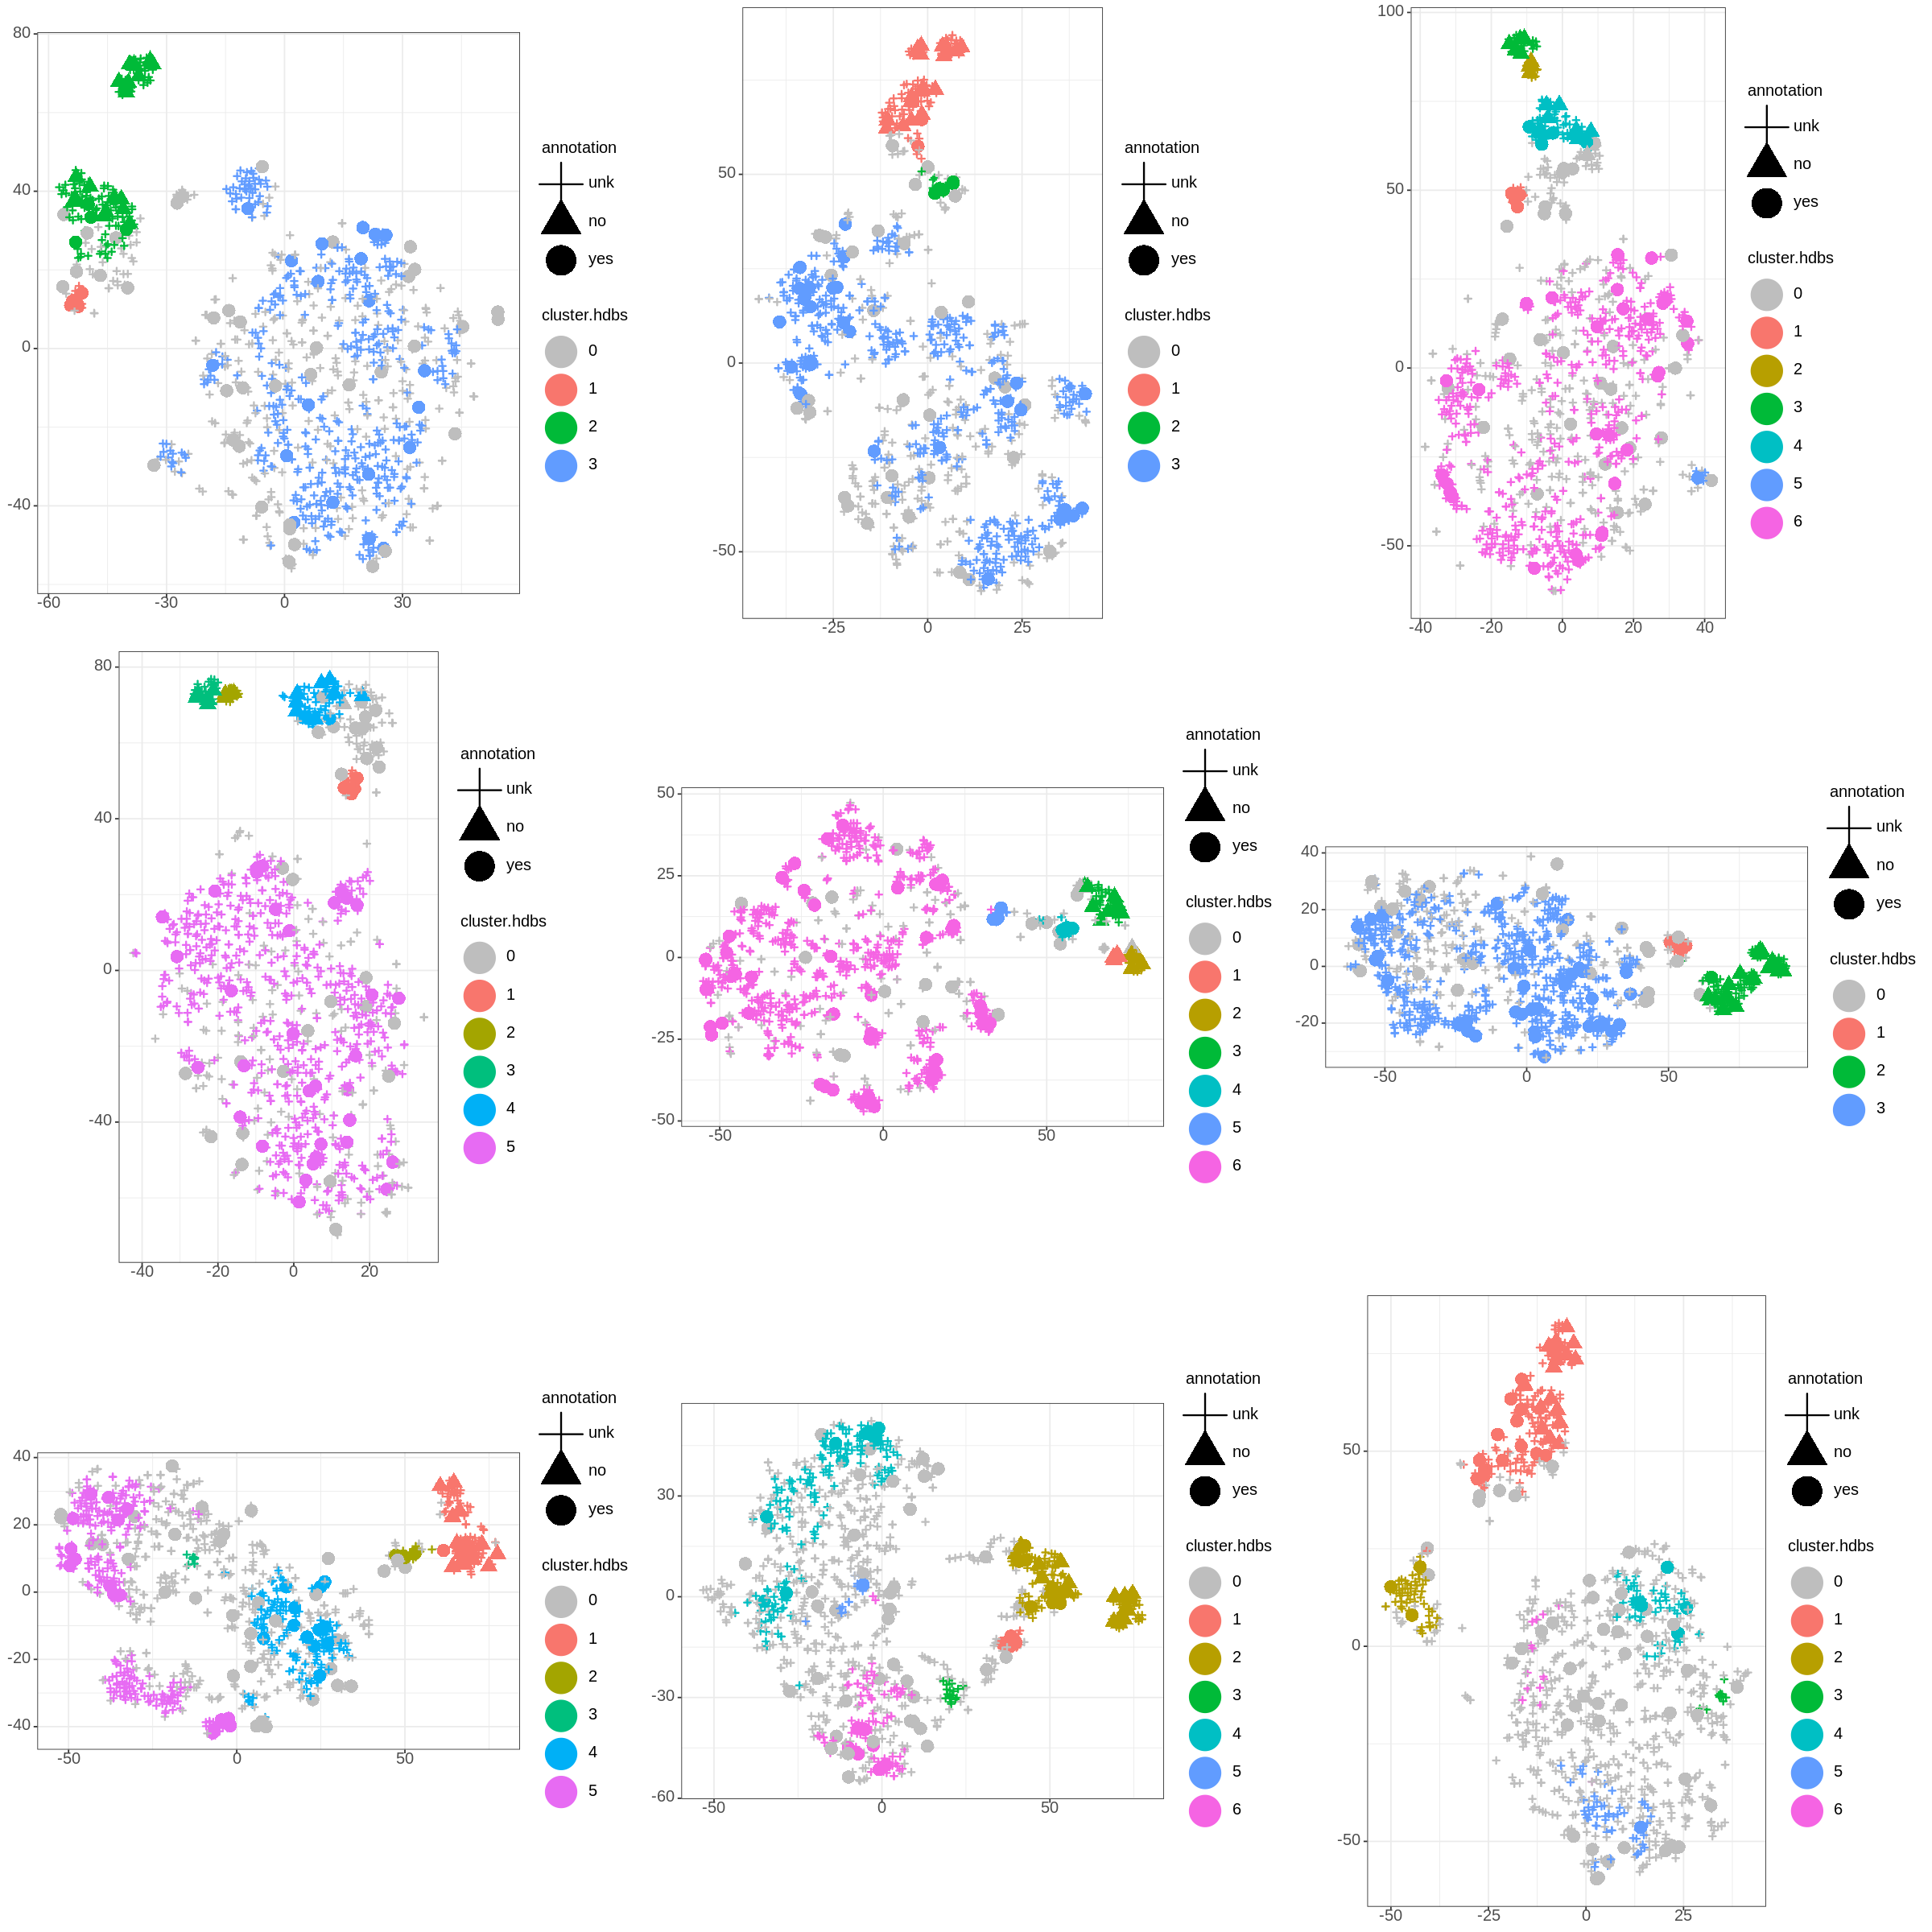

In [9]:
do.call("grid.arrange", c(plots_static1[['abuse']], ncol=3))

## Execute the different steps for the creation of onomasiological profiles
(this loop can take several hours, depending on the number of concepts)

In [ ]:
final_datasets_list <- list()
d.concepts <- data.frame()

for (concept in concepts[1:5]) {
  
  conceptName <- concept
  d.conceptsvariants.sub <- droplevels(subset(d.conceptsvariants, concept == conceptName))                                        
  
  lemmasSlash <- paste0(as.character(unlist(conceptsvariants[[concept]])),"/")
  Pattern <- paste0("^",lemmasSlash, collapse="|")
  allTokens <- startingTokens[grepl(Pattern, startingTokens)]
  
  d.ann.sub <- droplevels(subset(d.annotation2, concept == conceptName))
  rownames(d.ann.sub) <- d.ann.sub$Column2

  all.models <- tools::file_path_sans_ext(list.files(path=paste0(path,concept), pattern=".*npy$"))
  
  for (model in all.models) {
    
    # --------------------------------------------------- 
    # STEP 1: ALL DISAMBIGUATED TOKENS (1 MEASUREMENT PER CONCEPT)
    print("step 1")
    # ---------------------------------------------------
    
    wordform <- gsub("^([^/]+)/.+","\\1",allTokens,perl=T)
    lemma <- wordform      
    lemma <- as.factor(lemma)   
    levels(lemma) <- as.character(d.conceptsvariants.sub[which(d.conceptsvariants.sub$wordform %in% levels(lemma)),'lemma'])
    
    lect <- gsub("^[^/]+/.*(nrc1999|nrc2000|stan2000|stan1999|twitter-nl|twitter-be|usenet-nl|usenet-be|nrc2017|standaard2017|standaard2018|nrc2018).+",'\\1',allTokens,perl=T)
    country <- lect
    formality <- lect
    time <- lect
    
    country <- as.factor(country)
    levels(country)[grepl("(nrc|-nl)", levels(country))] <- "Netherlands"
    levels(country)[grepl("(standaard|stan|-be)", levels(country))] <- "Belgium"
    country <- factor(country, levels=c("Belgium","Netherlands"))
    
    formality <- as.factor(formality)
    levels(formality)[grepl("(nrc|stan)", levels(formality))] <- "formal"
    levels(formality)[grepl("(twitter|usenet)", levels(formality))] <- "informal"
    
    time <- as.factor(time)
    levels(time)[grepl("(2000|1999|usenet)", levels(time))] <- "time1"
    levels(time)[grepl("(2017|2018|twitter)", levels(time))] <- "time2"
    
    d.alltokens <- data.frame(allTokens, wordform, lemma, lect, country, formality, time)
    
    # ALL
    t.final <- table(lemma, country) 
    prop.proft <- round(prop.table(t.final, 2),10)
    
    u <- round(sum(apply(prop.proft, 1, min), na.rm=T), 10)
    iu <- round(sum(prop.table(rowSums(t.final))^2), 10)
    lect1.iu <- round(sum(prop.table(t.final[,1])^2), 10)
    lect2.iu <- round(sum(prop.table(t.final[,2])^2), 10)
    tot.tokens <- sum(t.final)
    
    step <- "all.disambiguated.tokens" 
    
    d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
    
    # ----------------------------
    
    cw = strsplit(model,"\\.")[[1]][2]
    foc_contribution = strsplit(model,"\\.")[[1]][3]
    ass_foc = strsplit(model,"\\.")[[1]][4]
    soc_selection = strsplit(model,"\\.")[[1]][5]
    svd = strsplit(model,"\\.")[[1]][6]
    
    print(model)
    flush.console()
    
    d <- np$load(paste0(path,concept,"/",model,".npy"))
    tokenids <- fromJSON(file = paste0(path,concept,"/",model,".meta"))
    
    colnames(d) <- tokenids$row_items
    rownames(d) <- tokenids$row_items
    
    tsvfile <- paste0(substr(model,1,nchar(model)-5),".tsv")
    
    # open and store dataframe
    d.context <- read.csv(paste0(path,"/",concept,"/",tsvfile), header=T, sep="\t", quote="", check.names = F)
    
    rownames(d.context) <- d.context$`_id`
    d.context$lemma <- d.context$word
    levels(d.context$lemma) <- as.character(d.conceptsvariants.sub[which(d.conceptsvariants.sub$wordform %in% levels(d.context$word)),'lemma'])
    
    subTokens <- intersect(rownames(d.context), rownames(d))
    
    dsub <- d[subTokens, subTokens] 
      d.context$in.out <- d.ann.sub[match(subTokens, as.character(d.context$`_id`)),"annotation"] 
      d.context$in.out <- as.character(d.context$in.out)
      d.context$in.out = d.context$in.out %>% replace_na('unk')
      d.context$in.out <- as.factor(d.context$in.out)
    
    dmx1 <- as.matrix(dsub) 
    ranks1 <- t(apply(dmx1, 1, rank))
    ranks1 <- log(1 + log(ranks1))
    dst <- as.dist(as.matrix(dist(ranks1, diag=T, upper=T)))
    
    # density-based cluster analysis 
    hdbs.output <- hdbscan(dst, minPts = 8)
    d.context$cluster.hdbs <- as.factor(as.character(hdbs.output$cluster))
    
    d.context$membership <- hdbs.output$membership_prob
    
    # --------------------------------------------------- 
    # STEP 2: MODELLED DISAMBIGUATED TOKENS (1 MEASURMENT PER MODEL)
    print("step 2")
    # ---------------------------------------------------
    
    # ALL
    t.final <- table(d.context$lemma, d.context$country) 
    prop.proft <- round(prop.table(t.final, 2),10)
    
    u <- round(sum(apply(prop.proft, 1, min), na.rm=T), 10)
    iu <- round(sum(prop.table(rowSums(t.final))^2), 10)
    lect1.iu <- round(sum(prop.table(t.final[,1])^2), 10)
    lect2.iu <- round(sum(prop.table(t.final[,2])^2), 10)
    tot.tokens <- sum(t.final)
    
    step <- "modelled.disambiguated.tokens" 
    d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
    
    # --------------------------------------------------- 
    # STEP 3: ALL MODELLED TOKENS EXCEPT FOR NOISE TOKENS
    print("step 3")
    # ---------------------------------------------------
    
    # ALL 
    d.context.nonoise.all <- droplevels(subset(d.context, cluster.hdbs != 0))
    
    if (nrow(d.context.nonoise.all) == 0){
        
        u <- NA
        iu <- NA
        lect1.iu <- NA
        lect2.iu <- NA
        tot.tokens <- 0
        
        step <- "nonoise" 
        d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
        step <- "nonoise.nomonolect" 
        d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
        step <- "nonoise.nomonolectal.noout" 
        d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))

    } else {
      t.final <- table(d.context.nonoise.all$lemma, d.context.nonoise.all$country) 
      prop.proft <- round(prop.table(t.final, 2),10)
      
      u <- round(sum(apply(prop.proft, 1, min), na.rm=T), 10)
      iu <- round(sum(prop.table(rowSums(t.final))^2), 10)
      lect1.iu <- round(sum(prop.table(t.final[,1])^2), 10)
      lect2.iu <- round(sum(prop.table(t.final[,2])^2), 10)
      tot.tokens <- sum(t.final)        
      
      step <- "nonoise" 
      d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
      
      # --------------------------------------------------- 
      # STEP 4: ALL MODELLED TOKENS EXCEPT FOR NOISE TOKENS AND EXCEPT FOR MONOLECTAL CLUSTERS
      print("step 4")
      # ---------------------------------------------------
      
      t.monolectal <- table(d.context.nonoise.all$cluster.hdbs, d.context.nonoise.all$country) 
      monolectal.clusters <- rownames(t.monolectal)[rowSums(t.monolectal == 0) == nlevels(d.context.nonoise.all$country) - 1] 
      
      # ALL 
      d.context.nonoise.nomonolectal.all <- droplevels(subset(d.context.nonoise.all, cluster.hdbs %ni% monolectal.clusters))
      # write.table(d.context.nonoise.nomonolectal.all, paste0("/home/projects/semmetrix/NephoSem/output-data/new-chapter10/models/",concept,"/",model,".nonoise.nomonolectal.tsv"), row.names=F, quote=F, sep="\t")
      
      t.final <- table(d.context.nonoise.nomonolectal.all$lemma, d.context.nonoise.nomonolectal.all$country) 
      prop.proft <- round(prop.table(t.final, 2),10)
      
      u <- round(sum(apply(prop.proft, 1, min), na.rm=T), 10)
      iu <- round(sum(prop.table(rowSums(t.final))^2), 10)
      lect1.iu <- round(sum(prop.table(t.final[,1])^2), 10)
      lect2.iu <- round(sum(prop.table(t.final[,2])^2), 10)
      tot.tokens <- sum(t.final)
      
      step <- "nonoise.nomonolect" 
      d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
      
      
      
      # --------------------------------------------------- 
      # STEP 5: ALL MODELLED TOKENS EXCEPT FOR NOISE TOKENS, EXCEPT FOR MONOLECTAL CLUSTERS AND
      #         EXCEPT FOR OUT-OF-CONCEPT CLUSTERS
      print("step 5")
      # ---------------------------------------------------
      
      tab <- table(d.context.nonoise.nomonolectal.all$cluster.hdbs, d.context.nonoise.nomonolectal.all$in.out)
      disambiguatedColumns <- colnames(tab)[!(colnames(tab) %in% "unk")]
      clustersWith10pDisambiguated <- rownames(tab[rowSums(tab[,disambiguatedColumns, drop=FALSE])/rowSums(tab) >= 0.1,])
      clustersWith5tDisambiguated <- rownames(tab[rowSums(tab[,disambiguatedColumns, drop=FALSE]) >= 5,])
      
      clustersRetained <- unique(c(clustersWith10pDisambiguated, clustersWith5tDisambiguated))
      
      tabFinalClusters <- tab[clustersRetained,]
      
      if (nrow(tabFinalClusters) == 0 | "yes" %ni% colnames(tabFinalClusters)) {
        in.clusters <- as.character()
      } else {
        pt <- prop.table(tabFinalClusters[,disambiguatedColumns, drop=FALSE],1)
        in.clusters <- rownames(pt)[pt[,"yes"] >= 0.8]            
      }
     
      if (length(in.clusters) != 0)  {
        
        # ALL 
        d.context.nonoise.noout.nomonolectal.all <- droplevels(subset(d.context.nonoise.nomonolectal.all, cluster.hdbs %in% in.clusters))
        d.context.nonoise.noout.nomonolectal.all$model <- model
        final_datasets_list[[concept]][[model]] <- d.context.nonoise.noout.nomonolectal.all
        
        
        t.final <- table(d.context.nonoise.noout.nomonolectal.all$lemma, d.context.nonoise.noout.nomonolectal.all$country) 
        prop.proft <- round(prop.table(t.final, 2),10)
        
        u <- round(sum(apply(prop.proft, 1, min), na.rm=T), 10)
        iu <- round(sum(prop.table(rowSums(t.final))^2), 10)
        lect1.iu <- round(sum(prop.table(t.final[,1])^2), 10)
        lect2.iu <- round(sum(prop.table(t.final[,2])^2), 10)
        tot.tokens <- sum(t.final)
        
        step <- "nonoise.nomonolectal.noout" 
        d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
        
      } else {
        
        u <- NA
        iu <- NA
        lect1.iu <- NA
        lect2.iu <- NA
        tot.tokens <- 0
        
        step <- "nonoise.nomonolectal.noout" 
        d.concepts <- bind_rows(d.concepts, cbind.data.frame(model, concept, step, u, iu, lect1.iu, lect2.iu, tot.tokens))
        
      }                     
    }
  }
}


In [ ]:
# how many models are removed after the stepwise profile-forming procedure

paste0(round(nrow(d.concepts[which(d.concepts$tot.tokens == 0 & d.concepts$step == "nonoise.nomonolectal.noout"),])/
nrow(d.concepts[which(d.concepts$step == "nonoise.nomonolectal.noout"),])*100), "%")

dKeptModels <- data.frame()
for (con in concepts) {
    
    kept.models <- nrow(d.concepts[which(d.concepts$tot.tokens == 0 & d.concepts$step == "nonoise.nomonolectal.noout" & d.concepts$concept == con),])/
    nrow(d.concepts[which(d.concepts$step == "nonoise.nomonolectal.noout" & d.concepts$concept == con),])
    
    cat(con,  paste0(round(kept.models*100),"%"),"\n")
    dKeptModels <- rbind(dKeptModels, cbind.data.frame(con, averageKeptModels = round(kept.models*100)))
    
}

In [ ]:
# how many tokens on average are kept in the remaning models

d.concepts[is.na(d.concepts$tot.tokens),"tot.tokens"] <- 0

ggplot(d.concepts, aes(x=step, y=tot.tokens)) + 
geom_bar(stat="summary", fun="mean") + 
geom_errorbar(stat="summary") + 
facet_wrap(~concept) + 
theme(axis.text.x = element_text(size=20, angle=45, vjust=0.5), 
      axis.text.y = element_text(size=20),
      axis.title = element_text(size=20), 
      strip.text = element_text(size = 20),
      legend.text = element_text(size=20),
      legend.title = element_text(size=20),
      plot.title = element_text(size=20))

d.concepts %>%
  group_by(concept) %>%
  summarize(DiffPerc = mean(tot.tokens[step == "nonoise.nomonolectal.noout"]/tot.tokens[step == "all.disambiguated.tokens"])) %>%
  arrange(desc(DiffPerc)) %>%
  mutate(DiffPerc = scales::percent(DiffPerc))

## Calculations of 'destandardization', 'informalization', 'dehomogeneization'

In [ ]:
d.conceptsvariants$partofspeech <- "noun"
d.conceptsvariants$semfield <- NA

d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[1:19]),]$partofspeech <- "adjective"
d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[20:25]),]$partofspeech <- "adverb"
d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[26:35]),]$partofspeech <- "verb"

d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[36:39]),]$semfield <- "science"
d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[40:44]),]$semfield <- "sports"
d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[45:53]),]$semfield <- "economy"
d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[54:64]),]$semfield <- "politics"
d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[65:76]),]$semfield <- "abstract"
d.conceptsvariants[which(d.conceptsvariants$concept %in% levels(d.conceptsvariants$concept)[77:85]),]$semfield <- "rest"

In [ ]:
d.concepts.clusters.demo <- data.frame()

for (concept in concepts) {
    
    print(concept)
    flush.console()
        
     for (model in names(final_datasets_list[[concept]])) { # ) {   
        d <- final_datasets_list[[concept]][[model]] 
    
        d.cluster <- d
          tot.tokens.cluster <- nrow(d.cluster)
        
          # destandardization Belgian-Dutch
            d.bel.per1 <- droplevels(subset(d.cluster, country == "Belgium" & timeperiod == "period1"))
            t.bel.per1 <- table(d.bel.per1$lemma, d.bel.per1$formality)
            sum.t.bel.per1 <- sum(t.bel.per1)

            
            if (ncol(t.bel.per1) == 2) {
              if (nrow(t.bel.per1) > 1) {
                if (fisher.test(t.bel.per1)$p.value < 0.05) {
                  prop.t.bel.per1 <- round(prop.table(t.bel.per1, 2),10)
                  u.bel.per1 <- round(sum(apply(prop.t.bel.per1, 1, min), na.rm=T), 10)
                } else {
                  u.bel.per1 <- 1
                }
              } else {
                u.bel.per1 <- 1
              }
            } else {
              u.bel.per1 <- NA
            }

            d.bel.per2 <- droplevels(subset(d.cluster, country == "Belgium" & timeperiod == "period2"))
            t.bel.per2 <- table(d.bel.per2$lemma, d.bel.per2$formality)
            sum.t.bel.per2 <- sum(t.bel.per2)

            
            if (ncol(t.bel.per2) == 2) {
              if (nrow(t.bel.per2) > 1) {
                if (fisher.test(t.bel.per2)$p.value < 0.05) {
                  prop.t.bel.per2 <- round(prop.table(t.bel.per2, 2),10)
                  u.bel.per2 <- round(sum(apply(prop.t.bel.per2, 1, min), na.rm=T), 10)
                } else {
                  u.bel.per2 <- 1
                }
              } else {
                u.bel.per2 <- 1
              }
            } else {
              u.bel.per2 <- NA
            }
  

         
          sum.t.bel <- sum.t.bel.per1 + sum.t.bel.per2
        
          # destandardization Netherlandic-Dutch
            d.ned.per1 <- droplevels(subset(d.cluster, country == "Netherlands" & timeperiod == "period1"))
            t.ned.per1 <- table(d.ned.per1$lemma, d.ned.per1$formality)
            sum.t.ned.per1 <- sum(t.ned.per1)

            if (ncol(t.ned.per1) == 2) {
              if (nrow(t.ned.per1) > 1) {
                if (fisher.test(t.ned.per1)$p.value < 0.05) {
                  prop.t.ned.per1 <- round(prop.table(t.ned.per1, 2),10)
                  u.ned.per1 <- round(sum(apply(prop.t.ned.per1, 1, min), na.rm=T), 10)
                } else {
                  u.ned.per1 <- 1
                }
              } else {
                u.ned.per1 <- 1
              }
            } else {
              u.ned.per1 <- NA
            }

            d.ned.per2 <- droplevels(subset(d.cluster, country == "Netherlands" & timeperiod == "period2"))
            t.ned.per2 <- table(d.ned.per2$lemma, d.ned.per2$formality)
            sum.t.ned.per2 <- sum(t.ned.per2)

            if (ncol(t.ned.per2) == 2) {
              if (nrow(t.ned.per2) > 1) {
                if (fisher.test(t.ned.per2)$p.value < 0.05) {
                  prop.t.ned.per2 <- round(prop.table(t.ned.per2, 2),10)
                  u.ned.per2 <- round(sum(apply(prop.t.ned.per2, 1, min), na.rm=T), 10)
                } else {
                  u.ned.per2 <- 1
                }
              } else {
                u.ned.per2 <- 1
              }
            } else {
              u.ned.per2 <- NA
            }
         
          sum.t.ned <- sum.t.ned.per1 + sum.t.ned.per2
 
          # informalization Belgian-Dutch
            d.bel <- subset(d.cluster, country == "Belgium")

            if (nlevels(droplevels(d.bel$formality)) == 2 & nlevels(droplevels(d.bel$timeperiod)) == 2) {

              beltab11 <- table(d.bel$lemma, d.bel$timeperiod, d.bel$formality)[,"period1","informal"]
              beltab12 <- table(d.bel$lemma, d.bel$timeperiod, d.bel$formality)[,"period2","formal"]
              belfintab1 <- matrix(c(beltab11, beltab12), nrow=length(beltab12))

            if (sum(belfintab1) != 0) {
              if (nrow(belfintab1) > 1) {
                if (fisher.test(belfintab1)$p.value < 0.05) {

                  bel.inf.per1 <- prop.table(table(d.bel$lemma, d.bel$timeperiod, d.bel$formality),c(2,3))[,"period1","informal"]
                  bel.for.per2 <- prop.table(table(d.bel$lemma, d.bel$timeperiod, d.bel$formality),c(2,3))[,"period2","formal"]
                  prop.t.bel.1 <- matrix(c(bel.inf.per1, bel.for.per2), nrow=length(bel.for.per2))
                  u.bel.inf.for.1 <- round(sum(apply(prop.t.bel.1, 1, min)), 10) 

                } else {
                  u.bel.inf.for.1 <- 1
                }
              } else {
                u.bel.inf.for.1 <- 1
              }
            } else {
              u.bel.inf.for.1 <- NA
            }

              beltab21 <- table(d.bel$lemma, d.bel$timeperiod, d.bel$formality)[,"period1","formal"]
              beltab22 <- table(d.bel$lemma, d.bel$timeperiod, d.bel$formality)[,"period2","informal"]
              belfintab2 <- matrix(c(beltab21, beltab22), nrow=length(beltab21))

            if (sum(belfintab2) != 0) {
              if (nrow(belfintab2) > 1) {
                if (fisher.test(belfintab2)$p.value < 0.05) {

                  bel.for.per1 <- prop.table(table(d.bel$lemma, d.bel$timeperiod, d.bel$formality),c(2,3))[,"period1","formal"]
                  bel.inf.per2 <- prop.table(table(d.bel$lemma, d.bel$timeperiod, d.bel$formality),c(2,3))[,"period2","informal"]
                  prop.t.bel.2 <- matrix(c(bel.for.per1, bel.inf.per2), nrow=length(bel.inf.per2))
                  u.bel.inf.for.2 <- round(sum(apply(prop.t.bel.2, 1, min)), 10)

                } else {
                  u.bel.inf.for.2 <- 1
                }
              } else {
                u.bel.inf.for.2 <- 1
              }
            } else {
              u.bel.inf.for.2 <- NA
            }

            } else {
              u.bel.inf.for.1 <- NA
              u.bel.inf.for.2 <- NA
            }         
        
          # informalization Netherlandic-Dutch
            d.ned <- subset(d.cluster, country == "Netherlands")

            if (nlevels(droplevels(d.ned$formality)) == 2 & nlevels(droplevels(d.ned$timeperiod)) == 2) {

              nedtab11 <- table(d.ned$lemma, d.ned$timeperiod, d.ned$formality)[,"period1","informal"]
              nedtab12 <- table(d.ned$lemma, d.ned$timeperiod, d.ned$formality)[,"period2","formal"]
              nedfintab1 <- matrix(c(nedtab11, nedtab12), nrow=length(nedtab12))
        
              if (sum(nedfintab1) != 0) {
                if (nrow(nedfintab1) > 1) {
                  if (fisher.test(nedfintab1)$p.value < 0.05) {

                    ned.inf.per1 <- prop.table(table(d.ned$lemma, d.ned$timeperiod, d.ned$formality),c(2,3))[,"period1","informal"]
                    ned.for.per2 <- prop.table(table(d.ned$lemma, d.ned$timeperiod, d.ned$formality),c(2,3))[,"period2","formal"]
                    prop.t.ned.1 <- matrix(c(ned.inf.per1, ned.for.per2), nrow=length(ned.for.per2))
                    u.ned.inf.for.1 <- round(sum(apply(prop.t.ned.1, 1, min)), 10) 

                  } else {
                    u.ned.inf.for.1 <- 1
                  }
                } else {
                  u.ned.inf.for.1 <- 1
                }
              } else {
                u.ned.inf.for.1 <- NA
              }

              nedtab21 <- table(d.ned$lemma, d.ned$timeperiod, d.ned$formality)[,"period1","formal"]
              nedtab22 <- table(d.ned$lemma, d.ned$timeperiod, d.ned$formality)[,"period2","informal"]
              nedfintab2 <- matrix(c(nedtab21, nedtab22), nrow=length(nedtab21))

              if (sum(nedfintab2) != 0) {
                if (nrow(nedfintab2) > 1) {
                  if (fisher.test(nedfintab2)$p.value < 0.05) {

                    ned.for.per1 <- prop.table(table(d.ned$lemma, d.ned$timeperiod, d.ned$formality),c(2,3))[,"period1","formal"]
                    ned.inf.per2 <- prop.table(table(d.ned$lemma, d.ned$timeperiod, d.ned$formality),c(2,3))[,"period2","informal"]
                    prop.t.ned.2 <- matrix(c(ned.for.per1, ned.inf.per2), nrow=length(ned.inf.per2))
                    u.ned.inf.for.2 <- round(sum(apply(prop.t.ned.2, 1, min)), 10)

                  } else {
                    u.ned.inf.for.2 <- 1
                  }
                } else {
                  u.ned.inf.for.2 <- 1
                }
              } else {
                u.ned.inf.for.2 <- NA
              }

            } else {
              u.ned.inf.for.1 <- NA
              u.ned.inf.for.2 <- NA
            } 
         
          # dehomogeneization Belgian-Dutch
          iu.bel.formal.per1 <-  tryCatch(round(sum(prop.table(t.bel.per1[,"formal"])^2), 10),  error=function(err) NA)
          iu.bel.formal.per2 <- tryCatch(round(sum(prop.table(t.bel.per2[,"formal"])^2), 10),  error=function(err) NA)

          # dehomogeneization Netherlandic-Dutch
          iu.ned.formal.per1 <- tryCatch(round(sum(prop.table(t.ned.per1[,"formal"])^2), 10),  error=function(err) NA)
          iu.ned.formal.per2 <- tryCatch(round(sum(prop.table(t.ned.per2[,"formal"])^2), 10),  error=function(err) NA)
        
         
        cw = strsplit(model,"\\.")[[1]][2]
        foc_contribution = strsplit(model,"\\.")[[1]][3]
        ass_foc = strsplit(model,"\\.")[[1]][4]
        soc_selection = strsplit(model,"\\.")[[1]][5]
        svd = strsplit(model,"\\.")[[1]][6]
        foc_selection = strsplit(model,"\\.")[[1]][7]

          d.concepts.clusters.demo <-   bind_rows(d.concepts.clusters.demo, cbind.data.frame(model.name=model, cw, foc_contribution, ass_foc, soc_selection, svd, foc_selection, concept, 
                                                                                             tot.tokens.cluster, freq.bel.per1 = sum.t.bel.per1, freq.bel.per2 = sum.t.bel.per2,
                                                                                             freq.ned.per1 = sum.t.ned.per1, freq.ned.per2 = sum.t.ned.per2,#cluster
                                                                                             freq.ned = sum.t.ned, freq.bel = sum.t.bel,
                                                                                             u.bel.per1, u.bel.per2, u.ned.per1, u.ned.per2,
                                                                                             u.bel.inf.for.1, u.bel.inf.for.2, u.ned.inf.for.1, u.ned.inf.for.2,
                                                                                             iu.bel.formal.per1, iu.bel.formal.per2, iu.ned.formal.per1, iu.ned.formal.per2))
                                                                                             }
    }

In [ ]:
d.concepts.clusters.demo <- merge(d.concepts.clusters.demo, 
                                  d.conceptsvariants[!duplicated(d.conceptsvariants$concept),c('concept','partofspeech','semfield')], 
                                  by="concept")

d.concepts.clusters.demo$Standardization.bel <- d.concepts.clusters.demo$u.bel.per2 - d.concepts.clusters.demo$u.bel.per1 
d.concepts.clusters.demo$Standardization.ned <- d.concepts.clusters.demo$u.ned.per2 - d.concepts.clusters.demo$u.ned.per1 

d.concepts.clusters.demo$Formalization.bel <- d.concepts.clusters.demo$u.bel.inf.for.2 - d.concepts.clusters.demo$u.bel.inf.for.1 
d.concepts.clusters.demo$Formalization.ned <- d.concepts.clusters.demo$u.ned.inf.for.2  - d.concepts.clusters.demo$u.ned.inf.for.1 

d.concepts.clusters.demo$Homogeneization.bel <- d.concepts.clusters.demo$iu.bel.formal.per2 - d.concepts.clusters.demo$iu.bel.formal.per1
d.concepts.clusters.demo$Homogeneization.ned <- d.concepts.clusters.demo$iu.ned.formal.per2  - d.concepts.clusters.demo$iu.ned.formal.per1 

In [ ]:
concept_count_proportion_merged <- merge(d.concepts.clusters.demo, concept_count_proportions, by="concept")

concept_count_proportion_merged$freq.bel <- concept_count_proportion_merged$freq.bel.per1 + concept_count_proportion_merged$freq.bel.per2
concept_count_proportion_merged$freq.ned <- concept_count_proportion_merged$freq.ned.per1 + concept_count_proportion_merged$freq.ned.per2

concept_count_proportion_merged$proportion_in <- concept_count_proportion_merged$tot.tokens.cluster/concept_count_proportion_merged$sample_size
concept_count_proportion_merged$proportion_in.bel <- concept_count_proportion_merged$freq.bel/concept_count_proportion_merged$sample_size
concept_count_proportion_merged$proportion_in.ned <- concept_count_proportion_merged$freq.ned/concept_count_proportion_merged$sample_size
concept_count_proportion_merged$proportion_in_bel.per1 <- concept_count_proportion_merged$freq.bel.per1/concept_count_proportion_merged$sample_size
concept_count_proportion_merged$proportion_in_bel.per2 <- concept_count_proportion_merged$freq.bel.per2/concept_count_proportion_merged$sample_size
concept_count_proportion_merged$proportion_in_ned.per1 <- concept_count_proportion_merged$freq.ned.per1/concept_count_proportion_merged$sample_size
concept_count_proportion_merged$proportion_in_ned.per2 <- concept_count_proportion_merged$freq.ned.per2/concept_count_proportion_merged$sample_size


concept_count_proportion_merged$final_size <- round(concept_count_proportion_merged$proportion_in * concept_count_proportion_merged$original_size)
concept_count_proportion_merged$final_size_bel <- round(concept_count_proportion_merged$proportion_in.bel * concept_count_proportion_merged$original_size)
concept_count_proportion_merged$final_size_ned <- round(concept_count_proportion_merged$proportion_in.ned * concept_count_proportion_merged$original_size)
concept_count_proportion_merged$final_size_bel.per1 <- round(concept_count_proportion_merged$proportion_in_bel.per1 * concept_count_proportion_merged$original_size)
concept_count_proportion_merged$final_size_bel.per2 <- round(concept_count_proportion_merged$proportion_in_bel.per2 * concept_count_proportion_merged$original_size)
concept_count_proportion_merged$final_size_ned.per1 <- round(concept_count_proportion_merged$proportion_in_ned.per1 * concept_count_proportion_merged$original_size)
concept_count_proportion_merged$final_size_ned.per2 <- round(concept_count_proportion_merged$proportion_in_ned.per2 * concept_count_proportion_merged$original_size)

concept_count_proportion_merged$parameters <- gsub(".+?(cw.+)","\\1", as.character(concept_count_proportion_merged$model.name))
                                          
dTemp <- concept_count_proportion_merged %>%
group_by(parameters) %>%
summarise(final_proportion = final_size/sum(final_size), 
          final_proportion.bel = final_size_bel/sum(final_size_bel),
          final_proportion.ned = final_size_ned/sum(final_size_ned),
          final_proportion.bel.per1 = final_size_bel.per1/sum(final_size_bel.per1),
          final_proportion.bel.per2 = final_size_bel.per2/sum(final_size_bel.per2),
          final_proportion.ned.per1 = final_size_ned.per1/sum(final_size_ned.per1),
          final_proportion.ned.per2 = final_size_ned.per2/sum(final_size_ned.per2),
          model.name)

concept_count_proportion_merged2 <- merge(concept_count_proportion_merged, dTemp , by="model.name")

In [ ]:
concept_count_proportion_merged2 %>% summarize(
                                      unweightedMean=mean(Formalization.bel, na.rm=T),
                                      unweightedSd = sd(Formalization.bel, na.rm=T),
                                      unweightedSe = sd(Formalization.bel, na.rm=T)/sqrt(nrow(.)),
    
                                      weightedMean.bel=weighted.mean(Formalization.bel, final_proportion.bel, na.rm=T),
                                      weightedSd.bel=sqrt(Hmisc::wtd.var(Formalization.bel, final_proportion.bel, method="ML")),
                                      weightedSe.bel=sqrt(Hmisc::wtd.var(Formalization.bel, final_proportion.bel, method="ML"))/sqrt(nrow(.)),
    
                                      weightedMean.bel.per1=weighted.mean(Formalization.bel, final_proportion.bel.per1, na.rm=T),
                                      weightedSd.bel.per1=sqrt(Hmisc::wtd.var(Formalization.bel, final_proportion.bel.per1, method="ML")),
                                      weightedSe.bel.per1=sqrt(Hmisc::wtd.var(Formalization.bel, final_proportion.bel.per1, method="ML"))/sqrt(nrow(.)),

                                      weightedMean.bel.per2=weighted.mean(Formalization.bel, final_proportion.bel.per2, na.rm=T),
                                      weightedSd.bel.per2=sqrt(Hmisc::wtd.var(Formalization.bel, final_proportion.bel.per2, method="ML")),
                                      weightedSe.bel.per2=sqrt(Hmisc::wtd.var(Formalization.bel, final_proportion.bel.per2, method="ML"))/sqrt(nrow(.)))

concept_count_proportion_merged2 %>% summarize(
                                      unweightedMean=mean(Formalization.ned, na.rm=T),
                                      unweightedSd = sd(Formalization.ned, na.rm=T),
                                      unweightedSe = sd(Formalization.ned, na.rm=T)/sqrt(nrow(.)),
    
                                      weightedMean.ned=weighted.mean(Formalization.ned, final_proportion.ned, na.rm=T),
                                      weightedSd.ned=sqrt(Hmisc::wtd.var(Formalization.ned, final_proportion.ned, method="ML")),
                                      weightedSe.ned=sqrt(Hmisc::wtd.var(Formalization.ned, final_proportion.ned, method="ML"))/sqrt(nrow(.)),
    
                                      weightedMean.ned.per1=weighted.mean(Formalization.ned, final_proportion.ned.per1, na.rm=T),
                                      weightedSd.ned.per1=sqrt(Hmisc::wtd.var(Formalization.ned, final_proportion.ned.per1, method="ML")),
                                      weightedSe.ned.per1=sqrt(Hmisc::wtd.var(Formalization.ned, final_proportion.ned.per1, method="ML"))/sqrt(nrow(.)),

                                      weightedMean.ned.per2=weighted.mean(Formalization.ned, final_proportion.ned.per2, na.rm=T),
                                      weightedSd.ned.per2=sqrt(Hmisc::wtd.var(Formalization.ned, final_proportion.ned.per2, method="ML")),
                                      weightedSe.ned.per2=sqrt(Hmisc::wtd.var(Formalization.ned, final_proportion.ned.per2, method="ML"))/sqrt(nrow(.)))

In [ ]:
concept_count_proportion_merged2$parameters.x <- as.factor(concept_count_proportion_merged2$parameters.x)

## Lectometric measurements per concept (Figures 9.3, 9.4, 9.8, 9.9, 9.13, 9.14)

In [ ]:
phen = c("Standardization.bel") # Formalization.bel, Homogeneization.bel
weight = c("final_size_bel")

dtemp <- concept_count_proportion_merged2 %>% group_by(concept) %>% summarize(unweightedMean=mean(get(phen), na.rm=T),
                                      unweightedSd = sd(get(phen), na.rm=T),
                                      unweightedSe = sd(get(phen), na.rm=T)/sqrt(nrow(.)),
                                      weightedMean=weighted.mean(get(phen), get(weight), na.rm=T),
                                      weightedSd=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T)),
                                      weightedSe=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T))/sqrt(nrow(.)),
#                                       simple.boot <- Hmisc::smean.cl.boot(Formalization.bel)
#                                       simple.boot.mean=Hmisc::smean.cl.boot(Formalization.bel)[[1]],
#                                       simple.boot.ci.lower=Hmisc::smean.cl.boot(Formalization.bel)[[2]],
#                                       simple.boot.ci.upper=Hmisc::smean.cl.boot(Formalization.bel)[[3]]
                                                                                  ) %>% mutate(concept = fct_reorder(concept, weightedMean))

(meanUM <- mean(dtemp$unweightedMean, na.rm=T))
(meanWM <- mean(dtemp$weightedMean, na.rm=T))

ggplot(dtemp, aes(y=concept, x=weightedMean)) +  geom_point(size=3, color="red") + geom_point(aes(y=concept, x=unweightedMean), size=3, color="blue") + 
geom_errorbar(aes(xmin=weightedMean-weightedSd, xmax=weightedMean+weightedSd), size=1) +
geom_vline(xintercept = 0, color="darkgreen", size=2) + 
xlim(-1, 1.1) + 
geom_vline(xintercept=meanUM, color="blue", size=2) + 
geom_vline(xintercept=meanWM, color="red", size=2) + 
theme(axis.text = element_text(size=20), 
      axis.title = element_blank(),
      strip.text.x = element_text(size = 40),
      axis.text.x = element_text(size = 40),
      legend.text = element_text(size=40),
      legend.title = element_text(size=40),
      plot.title = element_text(size=40))


In [ ]:
phen = c("Homogeneization.ned") # Standardization.ned, Formalization.ned
weight = c("final_size_ned")

dtemp <- concept_count_proportion_merged2 %>% group_by(concept) %>% summarize(unweightedMean=mean(get(phen), na.rm=T),
                                      unweightedSd = sd(get(phen), na.rm=T),
                                      unweightedSe = sd(get(phen), na.rm=T)/sqrt(nrow(.)),
                                      weightedMean=weighted.mean(get(phen), get(weight), na.rm=T),
                                      weightedSd=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T)),
                                      weightedSe=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T))/sqrt(nrow(.)),
                                                                                  ) %>% mutate(concepts = fct_reorder(concept, weightedMean))

(meanUM <- mean(dtemp$unweightedMean, na.rm=T))
(meanWM <- mean(dtemp$weightedMean, na.rm=T))

dtemp <- dtemp[!is.na(dtemp$unweightedMean),]

ggplot(dtemp, aes(y=concepts, x=weightedMean)) +  geom_point(size=3, color="red") + geom_point(aes(y=concepts, x=unweightedMean), size=3, color="blue") + 
geom_errorbar(aes(xmin=weightedMean-weightedSd, xmax=weightedMean+weightedSd), size=1) +
geom_vline(xintercept = 0, color="darkgreen", size=2) + 
xlim(-0.8, 1.1) + 
geom_vline(xintercept=meanUM, color="blue", size=2) + 
geom_vline(xintercept=meanWM, color="red", size=2) + 
theme(axis.text = element_text(size=20), 
      axis.title = element_blank(),
      strip.text.x = element_text(size = 40),
      axis.text.x = element_text(size = 40),
      legend.text = element_text(size=40),
      legend.title = element_text(size=40),
      plot.title = element_text(size=40))

## Lectometric measurements per model (Figures 9.1, 9.2, 9.6, 9.7, 9.11, 9.12)

In [ ]:
phen = c("Homogeneization.bel") # Standardization.bel, Formalization.bel
weight = c("final_size_bel") # final_size_ned

dtemp <- concept_count_proportion_merged2 %>% group_by(parameters.x) %>% summarize(unweightedMean=mean(get(phen), na.rm=T),
                                      unweightedSd = sd(get(phen), na.rm=T),
                                      unweightedSe = sd(get(phen), na.rm=T)/sqrt(nrow(.)),
                                      weightedMean=weighted.mean(get(phen), get(weight), na.rm=T),
                                      weightedSd=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T)),
                                      weightedSe=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T))/sqrt(nrow(.)),
                                                                                  ) %>% mutate(parameters.x = fct_reorder(parameters.x, weightedMean))

(meanUM <- mean(dtemp$unweightedMean))
(meanWM <- mean(dtemp$weightedMean))

ggplot(dtemp, aes(y=parameters.x, x=weightedMean)) +  geom_point(size=3, color="red") + geom_point(aes(y=parameters.x, x=unweightedMean), size=3, color="blue") + 
geom_errorbar(aes(xmin=weightedMean-weightedSd, xmax=weightedMean+weightedSd), size=1) +
geom_vline(xintercept = 0, color="darkgreen", size=2) + 
xlim(-0.5, 0.5) + 
geom_vline(xintercept=meanUM, color="blue", size=2) + 
geom_vline(xintercept=meanWM, color="red", size=2) + 
theme(#axis.text = element_text(size=10), 
      axis.ticks.y = element_line(size=3),
      axis.text.y = element_blank(), 
      axis.title = element_blank(),
      strip.text.x = element_text(size = 40),
      axis.text.x = element_text(size = 40),
      legend.text = element_text(size=40),
      legend.title = element_text(size=40),
      plot.title = element_text(size=40))

In [ ]:
phen = c("Homogeneization.ned") # Standardization.ned, Formalization.ned
weight = c("final_size_ned")

dtemp <- concept_count_proportion_merged2 %>% group_by(parameters.x) %>% summarize(unweightedMean=mean(get(phen), na.rm=T),
                                      unweightedSd = sd(get(phen), na.rm=T),
                                      unweightedSe = sd(get(phen), na.rm=T)/sqrt(nrow(.)),
                                      weightedMean=weighted.mean(get(phen), get(weight), na.rm=T),
                                      weightedSd=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T)),
                                      weightedSe=sqrt(Hmisc::wtd.var(get(phen), get(weight), method="unbiased", na.rm=T))/sqrt(nrow(.)),
                                                                                  ) %>% mutate(parameters.x = fct_reorder(parameters.x, weightedMean))

(meanUM <- mean(dtemp$unweightedMean))
(meanWM <- mean(dtemp$weightedMean))

ggplot(dtemp, aes(y=parameters.x, x=weightedMean)) +  geom_point(size=3, color="red") + geom_point(aes(y=parameters.x, x=unweightedMean), size=3, color="blue") + 
geom_errorbar(aes(xmin=weightedMean-weightedSd, xmax=weightedMean+weightedSd), size=1) +
geom_vline(xintercept = 0, color="darkgreen", size=2) + 
xlim(-0.5, 0.5) + 
geom_vline(xintercept=meanUM, color="blue", size=2) + 
geom_vline(xintercept=meanWM, color="red", size=2) + 
theme(#axis.text = element_text(size=10), 
      axis.ticks.y = element_line(size=3),
      axis.text.y = element_blank(), 
      axis.title = element_blank(),
      strip.text.x = element_text(size = 40),
      axis.text.x = element_text(size = 40),
      legend.text = element_text(size=40),
      legend.title = element_text(size=40),
      plot.title = element_text(size=40))

## Regression analysis for destandardization phenomena (Figures 9.5, 9.10, 9.15)

In [ ]:
# measvars = c("Formalization.bel","Formalization.ned")
# measvars = c("Standardization.bel","Standardization.ned")
measvars = c("Homogeneization.bel","Homogeneization.ned")

dreg <- reshape2::melt(concept_count_proportion_merged2[,c("concept","semfield","final_size", "partofspeech","cw","foc_contribution","ass_foc","soc_selection","svd","foc_selection","parameters.x", measvars)], measure.vars=measvars)

dreg <- dreg %>% mutate(variable = fct_recode(variable, "NED" = measvars[2], "BEL" = measvars[1]))
# summary(na.omit(dreg))
mod1 <- lmer(value~(semfield+cw+foc_contribution+ass_foc+soc_selection+svd+foc_selection+log(final_size))*variable+(1|parameters.x)+(1|concept), data=na.omit(dreg))

# summary(dreg)
# mod1 <- lmer(value~(partofspeech+cw+foc_contribution+ass_foc+soc_selection+svd+foc_selection+log(final_size))*variable+(1|parameters.x)+(1|concept), data=dreg)

# step(mod1)


## -- model for Formalization (nouns)
# mod.final <- lmer(value ~ semfield + log(final_size) + variable + (1 | concept) + semfield:variable, data=na.omit(dreg))

## -- model for Standardization (nouns)
# mod.final <- lmer(value ~ semfield + cw + ass_foc + variable + (1 | concept) + 
#    semfield:variable + cw:variable, data=na.omit(dreg))

## -- model for Heterogeneization (nouns)
mod.final <- lmer(value ~ semfield + soc_selection + log(final_size) + variable + 
   (1 | concept) + semfield:variable + log(final_size):variable, data=na.omit(dreg))

## -- model for Formalization (all)
# mod.final <- lmer(value ~ partofspeech + foc_contribution + log(final_size) + variable + 
#     (1 | concept) + partofspeech:variable + foc_contribution:variable, data=dreg)

## -- model for Standardization (all)
# mod.final <- lmer(value ~ partofspeech + cw + soc_selection + log(final_size) + 
#     variable + (1 | concept) + partofspeech:variable + cw:variable + 
#     log(final_size):variable, data=dreg)

## -- model for Heterogeneization (all)
# mod.final <- lmer(value ~ cw + foc_contribution + soc_selection + log(final_size) + 
#    variable + (1 | concept) + cw:variable + log(final_size):variable, data=dreg)


In [ ]:
lsm <- emmeans(mod.final, pairwise~semfield|variable, type="response", weights="proportional")$emmeans

lsm.sum <- summary(lsm)

ggplot(lsm.sum, aes(semfield, emmean,colour=variable,fill=variable)) + 
  geom_hline(aes(yintercept=0),linetype="dashed",colour="red") + 
  geom_bar(stat="identity", width = 0.7, position = position_dodge()) + 
  geom_errorbar(aes(ymin=asymp.LCL, ymax=asymp.UCL), width=0.7, position=position_dodge(),colour="black") +
 labs(x="semantic field") + coord_cartesian(ylim = c(-0.3,0.4)) +
  theme(axis.title.y=element_blank(), legend.position=c(0.10,0.90)) +
  scale_fill_manual(values=c("red","orange")) + scale_color_manual(values=c("red","orange")) + 
theme(axis.text = element_text(size=40), 
      axis.title = element_text(size=40),
      strip.text.x = element_text(size = 40),
      legend.text = element_text(size=40),
      legend.title = element_text(size=40))
